The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# *Pooling* de Atenção: Regressão de Kernel de Nadaraya-Watson 
:label:`sec_nadaraya-waston`

Agora você conhece os principais componentes dos mecanismos de atenção sob a estrutura em :numref:`fig_qkv`.
Para recapitular,
as interações entre
consultas (dicas volitivas) e chaves (dicas não volitivas)
resultam em *concentração de atenção*.
O *pooling* de atenção agrega valores seletivamente (entradas sensoriais) para produzir a saída.
Nesta secção,
vamos descrever o agrupamento de atenção em mais detalhes
para lhe dar uma visão de alto nível
como os mecanismos de atenção funcionam na prática.
Especificamente,
o modelo de regressão do kernel de Nadaraya-Watson
proposto em 1964
é um exemplo simples, mas completo
para demonstrar o aprendizado de máquina com mecanismos de atenção.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Gerando o Dataset


Para manter as coisas simples,
vamos considerar o seguinte problema de regressão:
dado um conjunto de dados de pares de entrada-saída $\{(x_1, y_1), \ldots, (x_n, y_n)\}$,
como aprender $f$ para prever a saída $\hat{y} = f(x)$ para qualquer nova entrada $x$?

Aqui, geramos um conjunto de dados artificial de acordo com a seguinte função não linear com o termo de ruído $\epsilon$:

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

onde $\epsilon$ obedece a uma distribuição normal com média zero e desvio padrão 0,5.
Ambos, 50 exemplos de treinamento e 50 exemplos de teste
são gerados.
Para visualizar melhor o padrão de atenção posteriormente, as entradas de treinamento são classificadas.


In [2]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

In [3]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

A função a seguir plota todos os exemplos de treinamento (representados por círculos),
a função de geração de dados de verdade básica `f` sem o termo de ruído (rotulado como "Truth"), e a função de predição aprendida (rotulado como "Pred").


In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## *Pooling* Médio

Começamos com talvez o estimador "mais idiota" do mundo para este problema de regressão:
usando o *pooling* médio para calcular a média de todos os resultados do treinamento:

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

que é plotado abaixo. Como podemos ver, este estimador não é tão inteligente.


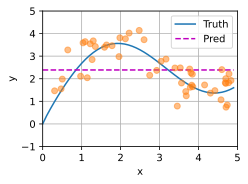

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## *Pooling* de Atenção não-Paramétrico

Obviamente,
o agrupamento médio omite as entradas $x_i$.
Uma ideia melhor foi proposta
por Nadaraya :cite:`Nadaraya.1964`
e Waston :cite:`Watson.1964`
para pesar as saídas $y_i$ de acordo com seus locais de entrada:

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-waston`

onde $K$ é um *kernel*.
O estimador em :eqref:`eq_nadaraya-waston`
é chamado de *regressão do kernel Nadaraya-Watson*.
Aqui não entraremos em detalhes sobre os grãos.
Lembre-se da estrutura dos mecanismos de atenção em :numref:`fig_qkv`.
Do ponto de vista da atenção,
podemos reescrever :eqref:`eq_nadaraya-waston`
em uma forma mais generalizada de *concentração de atenção*:

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`



onde $x$ é a consulta e $(x_i, y_i)$ é o par de valores-chave.
Comparando :eqref:`eq_attn-pooling` e :eqref:`eq_avg-pooling`,
a atenção concentrada aqui
é uma média ponderada de valores $y_i$.
O *peso de atenção* $\alpha(x, x_i)$
em :eqref:`eq_attn-pooling`
é atribuído ao valor correspondente $y_i$
baseado na interação
entre a consulta $x$ e a chave $x_i$
modelado por $\alpha$.
Para qualquer consulta, seus pesos de atenção sobre todos os pares de valores-chave são uma distribuição de probabilidade válida: eles não são negativos e somam um.

Para obter intuições de concentração de atenção,
apenas considere um *kernel gaussiano* definido como

$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).
$$


Conectando o kernel gaussiano em
:eqref:`eq_attn-pooling` e
:eqref:`eq_nadaraya-waston` dá

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian`


In :eqref:`eq_nadaraya-waston-gaussian`,
uma chave $x_i$ que está mais próxima da consulta dada $x$ obterá
*mais atenção * por meio de um *peso de atenção maior* atribuído ao valor correspondente da chave $y_i$.

Notavelmente, a regressão do kernel Nadaraya-Watson é um modelo não paramétrico;
assim :eqref:`eq_nadaraya-waston-gaussian`
é um exemplo de *agrupamento de atenção não paramétrica*.
A seguir, traçamos a previsão com base neste
modelo de atenção não paramétrica.
A linha prevista é suave e mais próxima da verdade fundamental do que a produzida pelo agrupamento médio.


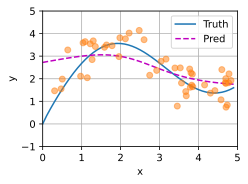

In [6]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

Agora, vamos dar uma olhada nos pesos de atenção.
Aqui, as entradas de teste são consultas, enquanto as entradas de treinamento são essenciais.
Uma vez que ambas as entradas são classificadas,
podemos ver que quanto mais próximo o par de chave de consulta está,
o maior peso de atenção está no *pooling* de atenção.


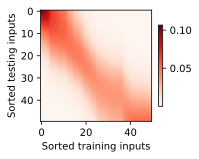

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## *Pooling* de Atenção Paramétrica


A regressão de kernel não paramétrica de Nadaraya-Watson
desfruta do benefício de *consistência*:
com dados suficientes, esse modelo converge para a solução ótima.
Não obstante,
podemos facilmente integrar parâmetros aprendíveis no *pooling* de atenção.

Por exemplo, um pouco diferente de :eqref:`eq_nadaraya-waston-gaussian`, na sequência
a distância entre a consulta $x$ e a chave $x_i$
é multiplicado por um parâmetro aprendível $w$:


$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_i)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian-para`

No resto da seção,
vamos treinar este modelo aprendendo o parâmetro de
a concentração de atenção em :eqref:`eq_nadaraya-waston-gaussian-para`.

### Multiplicação de Matriz de Lote
:label:`subsec_batch_dot`

Para computar a atenção com mais eficiência
para *minibatches*,
podemos aproveitar os utilitários de multiplicação de matrizes em lote
fornecidos por *frameworks* de *deep learning*.

Suponha que o primeiro minibatch contém $n$ matrizes $\mathbf{X}_1, \ldots, \mathbf{X}_n$ de forma $a\times b$, e o segundo minibatch contém $n$ matrizes $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$ da forma $b\times c$. Sua multiplicação da matriz de lote
resulta em
$n$ matrizes $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ da forma $a\times c$. Portanto, dados dois tensores de forma ($n$, $a$, $b$) e ($n$, $b$, $c$),  a forma de sua saída de multiplicação da matriz em lote é ($n$, $a$, $c$).


In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

No contexto dos mecanismos de atenção, podemos usar a multiplicação da matriz de minibatch para calcular médias ponderadas de valores em um minibatch.


In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

### Definindo o Modelo

Usando a multiplicação de matriz de minibatch,
abaixo nós definimos a versão paramétrica
da regressão do kernel Nadaraya-Watson
com base no agrupamento de atenção paramétrica em
:eqref:`eq_nadaraya-waston-gaussian-para`.


In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### Treinamento

A seguir, transformamos o conjunto de dados de treinamento
às chaves e valores para treinar o modelo de atenção.
No agrupamento paramétrico de atenção,
qualquer entrada de treinamento pega pares de valores-chave de todos os exemplos de treinamento, exceto ela mesma, para prever sua saída.


In [11]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

Usando a perda quadrada e a descida do gradiente estocástico,
treinamos o modelo paramétrico de atenção.


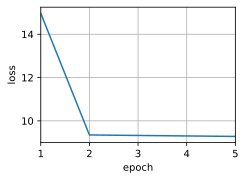

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

Depois de treinar o modelo paramétrico de atenção,
podemos traçar sua previsão.
Tentando ajustar o conjunto de dados de treinamento com ruído,
a linha prevista é menos suave
do que sua contraparte não paramétrica que foi traçada anteriormente.


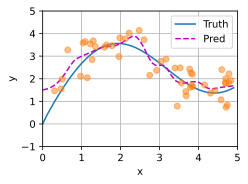

In [13]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

Comparando com o *pooling* de atenção não paramétrico,
a região com grandes pesos de atenção torna-se mais nítida
na configuração programável e paramétrica.


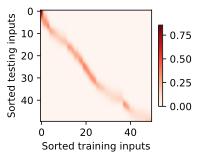

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## Resumo

* A regressão do kernel Nadaraya-Watson é um exemplo de *machine learning* com mecanismos de atenção.
* O agrupamento de atenção da regressão do kernel Nadaraya-Watson é uma média ponderada dos resultados do treinamento. Do ponto de vista da atenção, o peso da atenção é atribuído a um valor com base em uma função de uma consulta e a chave que está emparelhada com o valor.
* O *pooling* de atenção pode ser não paramétrico ou paramétrico.


## Exercícios

1. Aumente o número de exemplos de treinamento. Você pode aprender melhor a regressão de kernel não paramétrica Nadaraya-Watson?
1. Qual é o valor de nosso $w$ aprendido no experimento paramétrico de concentração de atenção? Por que torna a região ponderada mais nítida ao visualizar os pesos de atenção?
1. Como podemos adicionar hiperparâmetros à regressão de kernel Nadaraya-Watson não paramétrica para prever melhor?
1. Projete outro agrupamento de atenção paramétrica para a regressão do kernel desta seção. Treine este novo modelo e visualize seus pesos de atenção.


[Discussions](https://discuss.d2l.ai/t/1599)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIxMzMzNjQwMTMsMTcxMzY3NTY3NiwtNT
IwMDgwODk0LC00NjE1NDQ5MTksOTYxMzY5NDE1XX0=
-->
